In [262]:
import os
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
import xgboost as xgb

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, recall_score, auc,roc_curve, precision_score
# from collections import Counter, defaultdict
# from copy import deepcopy
# from operator import itemgetter
# from random import shuffle
# import scipy
# from matplotlib import pylab, gridspec, pyplot as plt
# from IPython.display import Image
# import urllib
# import seaborn as sns

# from sklearn.metrics import accuracy_score
# from sklearn import metrics, neighbors, dummy, preprocessing, svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
# from sklearn import linear_model
# from sklearn.neighbors import KNeighborsClassifier

# from sklearn import cross_validation
# from pandas.tools.plotting import scatter_matrix
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import ElasticNet
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVC
# from sklearn.svm import SVR
# from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,  AdaBoostClassifier
# from sklearn.metrics import mean_squared_error
# from sklearn import linear_model
# from sklearn.linear_model import Ridge

# from matplotlib import pyplot
# import matplotlib
# %matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 50) 

### Functions

In [189]:
def feature_description(feature, data, barplot = None):
    print('Analyzed feature: ',feature)
    
    if (data[feature].dtypes == 'int64') & (barplot == None):
        
        plt.figure(figsize=(10,5)) 
        plt.hist(data[feature]);

        # look at destribution depends on target
        sns.catplot(x=feature, y="bad_client_target",
                        kind="box", orient="h", data=data);
        
    else:
        # look at destribution
        data[feature].value_counts().plot(kind='bar');

        # look at destribution depends on target
        sns.catplot(x=feature, y="bad_client_target",  kind="bar", data=data);
 

In [190]:
def encode_and_bind(original_dataframe, feature_to_encode):

    """
This fucnction makes One-hot-encoding
    Input: 
    - datatable with deal_kul_id and need features
    - feature for One-hot-encoding
    Output: 
    - datatable with One-hot-encoding features
    
    """
    #1. Make dummies and OHE     
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1).drop(feature_to_encode, axis=1)
    
    return(res)

In [191]:
def feature_important(model):
    
    """
This fucnction shows feature imortants
    Input: 
    - model  
    
    Output: 
    - table with score of feature importants
    - plot with score of feature importants
    
    """    

    feature_important = model.get_booster().get_score(importance_type='weight')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    global data
    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    data.plot(kind='barh');

    return data  

In [192]:
def GS_table(learning_rate, max_depth, n_estimators, subsample, colsample_bytree, gamma,i_index  ):
    """
This fucnction makes GS table
    Input: 
    - parameres for greed search : learning_rate, max_depth, n_estimators, subsample, colsample_bytree, gamma,i_index
    
    Output: 
    - GS table
    
    """ 
    
    # 1. Data preporation
    learning_rate = pd.DataFrame(learning_rate, columns = ['learning_rate'])
    max_depth = pd.DataFrame(max_depth, columns = ['max_depth'])
    n_estimators = pd.DataFrame(n_estimators, columns = ['n_estimators'])
    subsample = pd.DataFrame(subsample, columns = ['subsample'])
    colsample_bytree = pd.DataFrame(colsample_bytree, columns = ['colsample_bytree'])
    gamma= pd.DataFrame(gamma, columns = ['gamma'])
    i_index = pd.DataFrame(i_index, columns = ['i_index'])
    
    
    # 2. Technical moments
    learning_rate['key'] = 0
    n_estimators['key'] = 0
    subsample['key'] = 0
    max_depth['key'] = 0
    colsample_bytree['key'] = 0
    gamma['key'] = 0
    i_index['key'] = 0
    
    
    # 3. Merge data     
    global grid_tab
    grid_tab = pd.merge(learning_rate, n_estimators, how = 'outer').\
    merge(subsample, how = 'outer' ).\
    merge(max_depth, how = 'outer' ).\
    merge(colsample_bytree, how = 'outer' ).\
    merge(gamma, how = 'outer' ).\
    merge(i_index, how = 'outer' ).\
    drop('key', axis= 1)
    
    # 4. Assign mae  
    grid_tab['auc1'] = 0.0
    grid_tab['auc2'] = 0.0
    grid_tab['auc3'] = 0.0
    grid_tab['auc_avg'] = 0.0

    # 5 Show shape grd_data
    print(grid_tab.shape)

### Part 1. Look at data


#### 1. Download data

In [193]:
# 1. Set path and download data 

path = os.path.dirname(os.path.abspath('__file__'))
data = pd.read_csv(path.replace('project', '')+'data\\clients.csv', sep=',' )

print('data shape:',data.shape)
data.head()

data shape: (1723, 14)


,month,credit_amount,credit_term,age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,male,Secondary special education,Cell phones,0,2,21000,Another,0,0,0
1,1,19000,6,20,male,Secondary special education,Household appliances,1,2,17000,Another,3,1,0
2,1,29000,12,23,female,Secondary special education,Household appliances,0,2,31000,Another,2,0,0
3,1,10000,12,30,male,Secondary special education,Cell phones,1,2,31000,Unmarried,3,1,0
4,1,14500,12,25,female,Higher education,Cell phones,0,2,26000,Married,0,1,0


#### 2.Main description

In [194]:
# 1. Main description
data.describe()

,month,credit_amount,credit_term,age,having_children_flg,region,income,phone_operator,is_client,bad_client_target
count,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000
mean,6.708067,29264.654672,11.546721,35.911782,0.428323,1.681370,32652.350551,1.125363,0.604759,0.113755
std,3.538420,27926.778301,6.548354,13.120203,0.494979,0.704256,20913.193158,1.015822,0.489044,0.317606
min,1.000000,5000.000000,3.000000,18.000000,0.000000,0.000000,1000.000000,0.000000,0.000000,0.000000
25%,3.000000,13000.000000,6.000000,26.000000,0.000000,2.000000,21000.000000,0.000000,0.000000,0.000000
50%,7.000000,21500.000000,12.000000,32.000000,0.000000,2.000000,27000.000000,1.000000,1.000000,0.000000
75%,10.000000,34000.000000,12.000000,44.000000,1.000000,2.000000,38000.000000,2.000000,1.000000,0.000000
max,12.000000,301000.000000,36.000000,90.000000,1.000000,2.000000,401000.000000,4.000000,1.000000,1.000000


In [195]:
# 2. Look at NA
data.isna().sum()


month                  0
credit_amount          0
credit_term            0
age                    0
sex                    0
education              0
product_type           0
having_children_flg    0
region                 0
income                 0
family_status          0
phone_operator         0
is_client              0
bad_client_target      0
dtype: int64

In [196]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   month                1723 non-null   int64 
 1   credit_amount        1723 non-null   int64 
 2   credit_term          1723 non-null   int64 
 3   age                  1723 non-null   int64 
 4   sex                  1723 non-null   object
 5   education            1723 non-null   object
 6   product_type         1723 non-null   object
 7   having_children_flg  1723 non-null   int64 
 8   region               1723 non-null   int64 
 9   income               1723 non-null   int64 
 10  family_status        1723 non-null   object
 11  phone_operator       1723 non-null   int64 
 12  is_client            1723 non-null   int64 
 13  bad_client_target    1723 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 188.6+ KB


#### Conclusion:
1. No problem with na
2. We can change type for sex and family_status

#### 3. Look at dependent variable

0    1527
1     196
Name: bad_client_target, dtype: int64

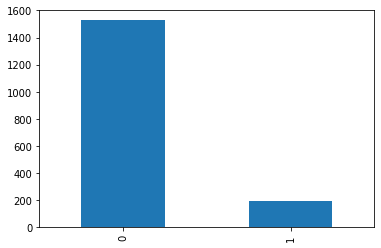

In [197]:
data['bad_client_target'].value_counts().plot(kind='bar');
data.bad_client_target.value_counts()

#### Conclusion:
1. There is an imbalance problem

#### 4. Look at independent variable

Analyzed feature:  month


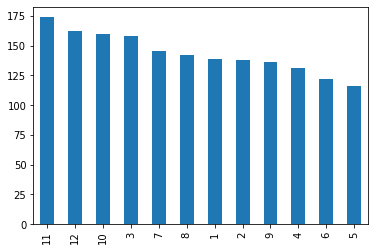

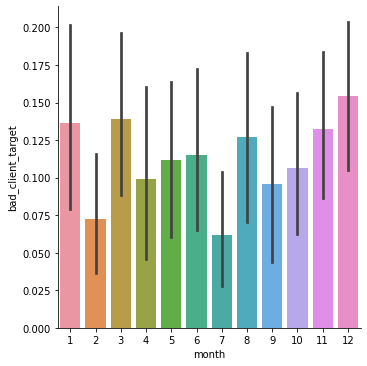

In [198]:
# 1. feature

feature = data.columns[0]
feature_description(feature, data,barplot =True)

#### Conclusion:
1. Majority bad clients in december
2. Minority in July

Analyzed feature:  credit_amount


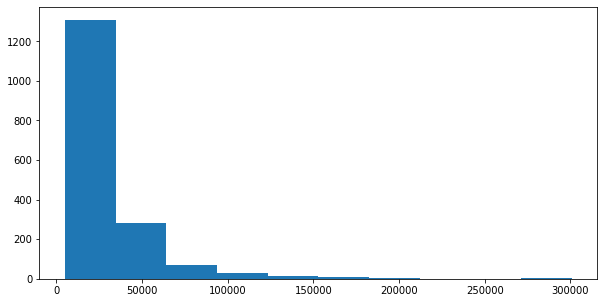

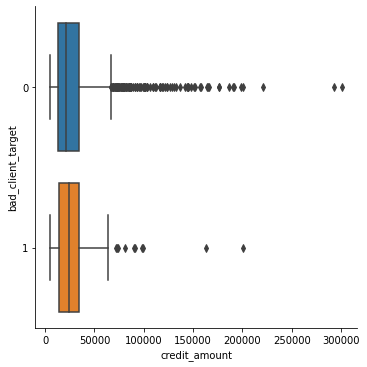

In [199]:
# 2. feature

feature = data.columns[1]
feature_description(feature, data)

In [200]:
# change data
data['big_credit_amount'] = np.where(data[feature] < np.quantile(data[feature],0.95), 0, 1)

Analyzed feature:  credit_term


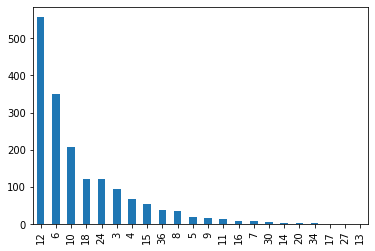

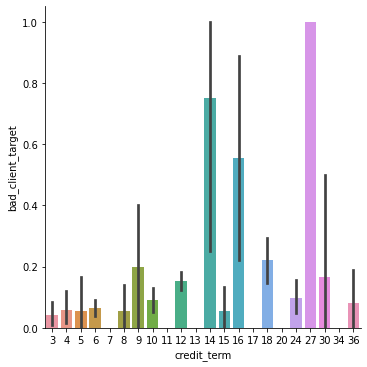

In [201]:
# feature

feature = data.columns[2]
feature_description(feature, data,barplot =True)

#### Conclusion:
1. Almost 100% bad clents with credit term = 27 but the q of them is not enoght
2. It is good to create a feature wich show that credit term is high
3. The share of bad clients higher for long term

Analyzed feature:  age


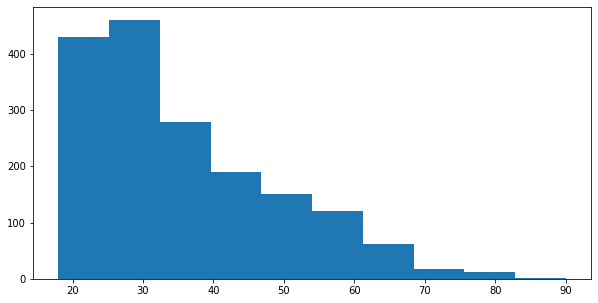

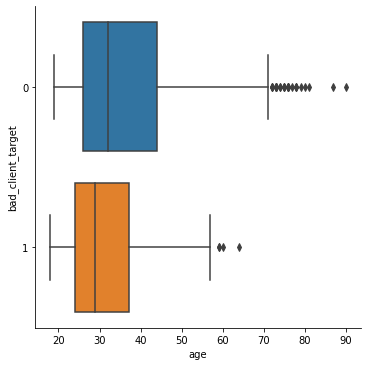

In [202]:
# feature

feature = data.columns[3]
feature_description(feature, data)

#### Conclusion:
Younger people are more likely bad clients

Analyzed feature:  sex


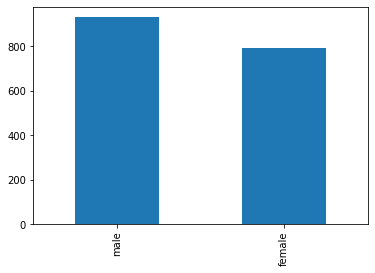

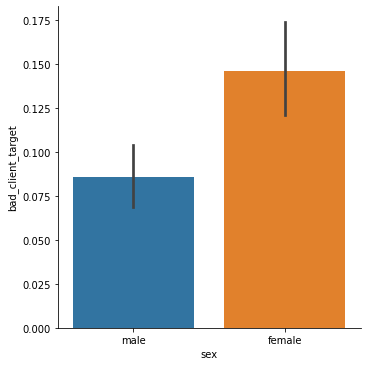

In [203]:
# feature

feature = data.columns[4]
feature_description(feature, data)

In [204]:
# change data
data['is_male'] = np.where(data[feature].isin(['male']), 1,0)


#### Conclusion:
Female are more likely bad clients

Analyzed feature:  education


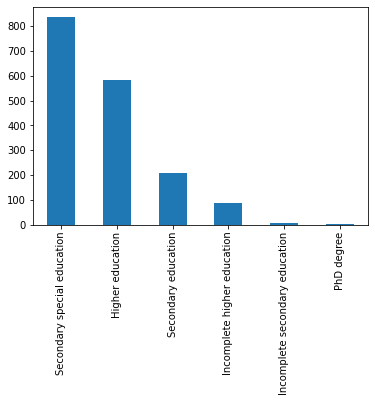

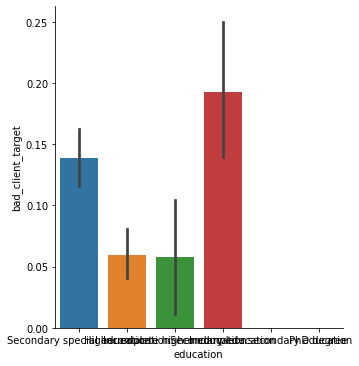

In [205]:
# feature

feature = data.columns[5]
feature_description(feature, data)

In [206]:
# change data
data[feature] = np.where(data[feature].isin(['PhD degree', 'Incomplete secondary education']), 'Other', data[feature])


#### Conclusion:
Bad education influences on type of clint in a negative way

Analyzed feature:  product_type


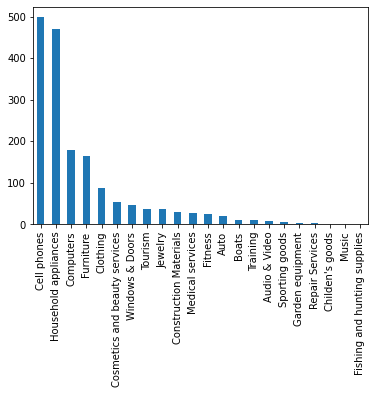

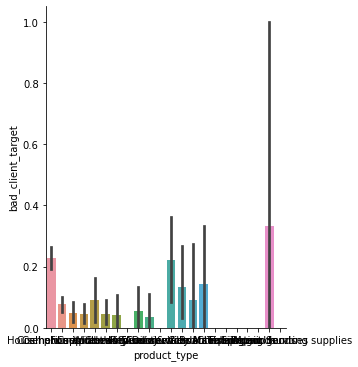

In [207]:
# feature

feature = data.columns[6]
feature_description(feature, data)

In [208]:
data[feature] = np.where(data[feature].isin(['Cell phones']), 'Cell phones', 
                         np.where(data[feature].isin(['Household appliances']), 'Household appliances',
                                  np.where(data[feature].isin(['Computers']), 'Computers',
                                           np.where(data[feature].isin(['Furniture']), 'Furniture',
                                                    np.where(data[feature].isin(['Clothing']), 'Clothing',
                                                             np.where(data[feature].isin(['Cosmetics and beauty services']), 'Cosmetics',
                                                                      'Other'))))))


Analyzed feature:  product_type


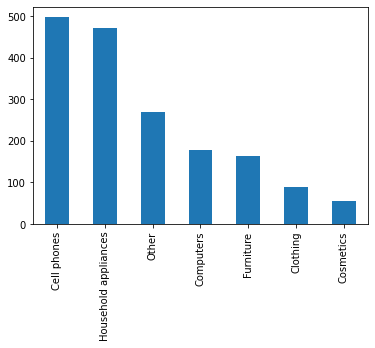

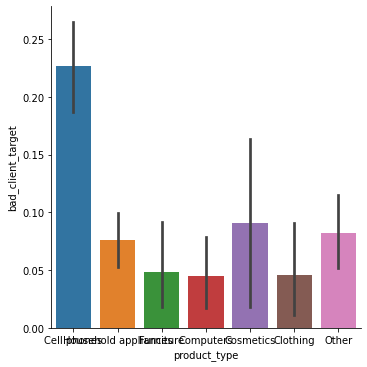

In [209]:
# feature

feature = data.columns[6]
feature_description(feature, data)

Analyzed feature:  having_children_flg


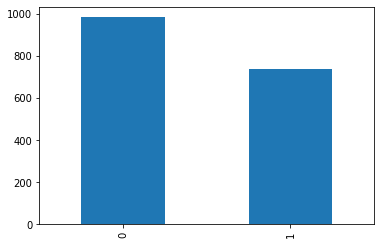

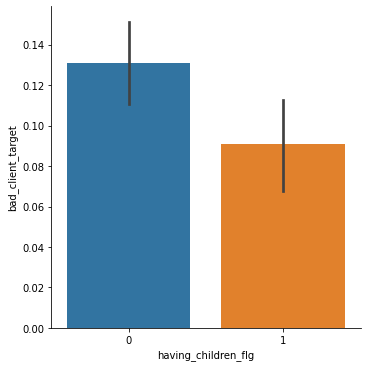

In [210]:
# feature

feature = data.columns[7]
feature_description(feature, data, barplot= True)

#### Conclusion:
If a clent has a children it is more likely that he/she is not a bad client

Analyzed feature:  region


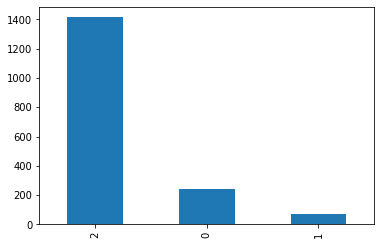

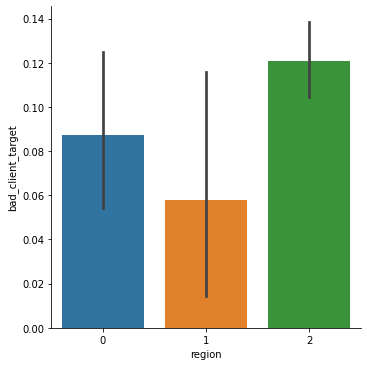

In [211]:
# feature

feature = data.columns[8]
feature_description(feature, data, barplot= True)

Analyzed feature:  income


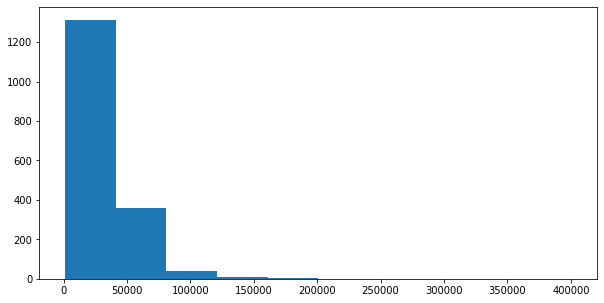

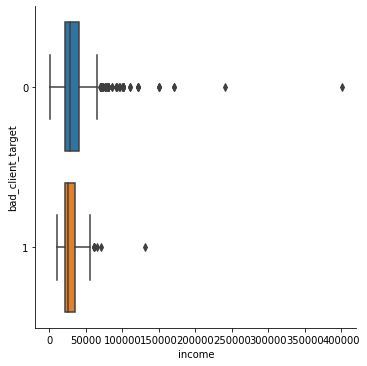

In [212]:
# feature

feature = data.columns[9]
feature_description(feature, data)

In [213]:
# change data
data['big_income'] = np.where(data[feature] < np.quantile(data[feature],0.95), 0, 1)

Analyzed feature:  family_status


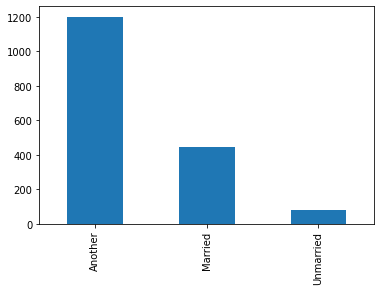

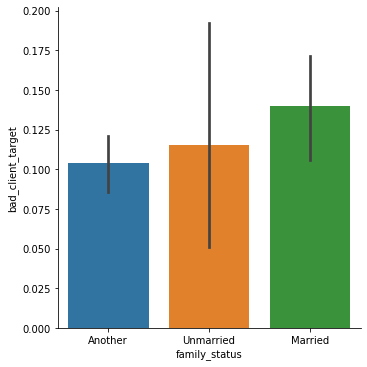

In [214]:
# feature

feature = data.columns[10]
feature_description(feature, data)

#### Conclusion:
 If a clent is married it is more likely that he/she is not a bad client

Analyzed feature:  phone_operator


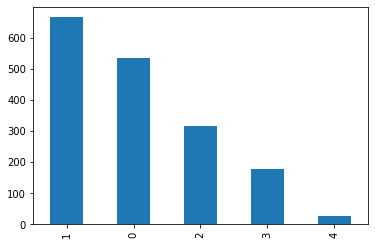

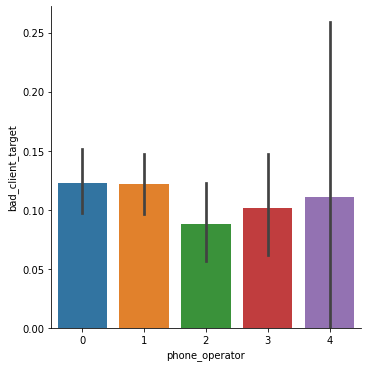

In [215]:
# feature

feature = data.columns[11]
feature_description(feature, data, barplot= True)

Analyzed feature:  is_client


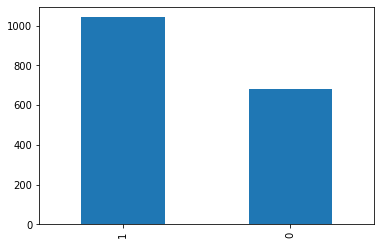

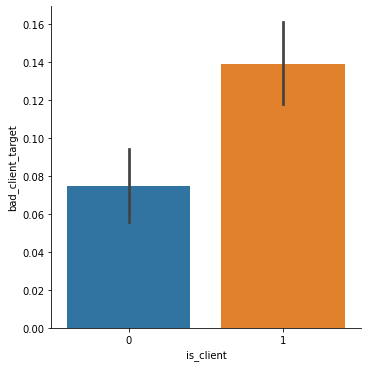

In [216]:
# feature

feature = data.columns[12]
feature_description(feature, data, barplot= True)

#### Conclusion:
If a clent is is_clents it is more likely that he/she is not a bad client

#### 5. Delete useless vars and make new column

In [217]:
data = data.drop(['sex'], axis =1)
# data['id'] = np.arange(0,len(data))



### Part 2. Preprocessing

#### 2.1 One-hot-encoding

In [218]:
# OHE
data = encode_and_bind(data , 'education')
data = encode_and_bind(data , 'product_type')
data = encode_and_bind(data , 'family_status')

In [219]:
# Swap data
data = data[['bad_client_target', 'month', 'credit_amount', 'credit_term', 'age', 'having_children_flg',
       'region', 'income', 'phone_operator', 'is_client',
       'big_credit_amount', 'is_male', 'big_income', 
       'education_Higher education', 'education_Incomplete higher education',
       'education_Other', 'education_Secondary education',
       'education_Secondary special education', 'product_type_Cell phones',
       'product_type_Clothing', 'product_type_Computers',
       'product_type_Cosmetics', 'product_type_Furniture',
       'product_type_Household appliances', 'product_type_Other',
       'family_status_Another', 'family_status_Married',
       'family_status_Unmarried']]

data =  data.rename(columns={'bad_client_target':'y'})

#### 2.2 Train and test split

In [220]:
# split data on target and X
train = data.iloc[:,1:]
y = data.y


# split data on train data set
x_train, x_test, y_train, y_test = train_test_split(train,  y, test_size=0.3, random_state=42);
print(x_train.shape)
print(x_test.shape)


(1206, 27)
(517, 27)


### Part 2. Moddelling. Naive XGBoost

In [221]:
%%time

threshold = 0.25
# 1. fitting 

xg_reg = xgb.XGBClassifier( n_jobs=5, random_state=777, objective='reg:logistic', use_label_encoder=False)
xg_reg.fit(x_train, y_train)


# 2. Prediction
prediction = xg_reg.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
print('AUC: ', round(auc(fpr, tpr),2))


# 3. Prediction + threshold
prediction = np.where(prediction < threshold, 0, 1)


print('recall: ', round(recall_score(y_pred = prediction, y_true = y_test),2))
print(confusion_matrix(y_test, prediction))


AUC:  0.68
recall:  0.18
[[432  30]
 [ 45  10]]
Wall time: 129 ms


#### 2.3 Feature importance 

,score
credit_amount,407
age,315
income,260
month,209
credit_term,125
phone_operator,111
product_type_Cell phones,52
education_Secondary special education,44
having_children_flg,41
family_status_Married,41


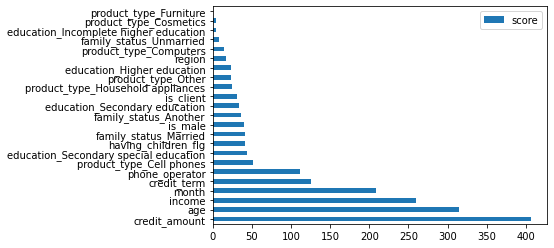

In [222]:
# 1. Select data with feature_importants

feature_important(xg_reg)

In [223]:
# 3. Select need features
threshold = 38

data = data.reset_index()
data = data[data.score>threshold]
columns = list(data['index'])


# 4. Select only interesting columns duruing training
x_train = x_train[columns]
x_test = x_test[x_train.columns]

#### 2.4 Naive XGBoost model with prune data

In [224]:
%%time

threshold = 0.25
# 1. fitting 

xg_reg = xgb.XGBClassifier( n_jobs=5, random_state=777, objective='reg:logistic', use_label_encoder=False)
xg_reg.fit(x_train, y_train)


# 2. Prediction
prediction = xg_reg.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
print('AUC: ', round(auc(fpr, tpr),2))


# 3. Prediction + threshold
prediction = np.where(prediction < threshold, 0, 1)


print('recall: ', round(recall_score(y_pred = prediction, y_true = y_test),2))
print(confusion_matrix(y_test, prediction))

AUC:  0.69
recall:  0.22
[[421  41]
 [ 43  12]]
Wall time: 118 ms


#### 2.5 Grid Search

In [225]:
# 1. Determine param for GS
learning_rate = [0.01,0.1,0.2,0.3] 
max_depth = [5,7,3] 
n_estimators = [100,200] 
subsample=  [1,0.75] 
colsample_bytree = [ 1]
gamma = [0.25, 0.1,0.2,0.3, 0]
i_index = [ 0]



# 2. Create GS table
GS_table(learning_rate, max_depth, n_estimators, subsample, colsample_bytree, gamma,i_index  )

(240, 11)


In [226]:
# 3. Data and folds fo GS
data = x_train.copy()
data['y'] = y_train 

# 3.1 Create folds
random.seed(777)
value = []
for i in range(0,len(data)):
    value.append(random.randint(1,3))
data['fold'] = value

In [227]:
# 3. Make GS and folds fo GS
for i in range(0,len(grid_tab)):
    for j in [1,2,3]:
        data_test = data[data.fold == j]
        data_train = data[data.fold != j]
    
    
    
        xg_reg = xgb.XGBClassifier(n_jobs=7, random_state=7,
                                 learning_rate = grid_tab.learning_rate[i],
                                 max_depth = grid_tab.max_depth[i],
                                 n_estimators = grid_tab.n_estimators[i],
                                 subsample = grid_tab.subsample[i],
                                 colsample_bytree = grid_tab.colsample_bytree[i],
                                 gamma = grid_tab.gamma[i],
                                objective='reg:logistic', use_label_encoder=False
                                 )
        xg_reg.fit(data_train.iloc[:,:(len(data_train.columns)-2)], data_train.y)

#         # 2. Prediction
        prediction = xg_reg.predict_proba(data_test.iloc[:,:(len(data_train.columns)-2)])[:, 1]
        fpr, tpr, thresholds = roc_curve(data_test.y, prediction)
        metric = round(auc(fpr, tpr),2)
    
# 6. Mae calculation for slices        
        if j == 1:
            grid_tab.auc1[i] = metric 
        elif j ==2:
            grid_tab.auc2[i] = metric 
        else:
            grid_tab.auc3[i] = metric    

                
# 7. MAE avg
    grid_tab.auc_avg = (grid_tab.auc1 + grid_tab.auc2+ grid_tab.auc3)/3      
    print(i)
    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


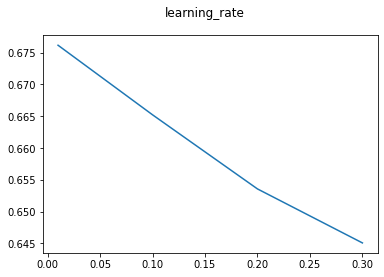

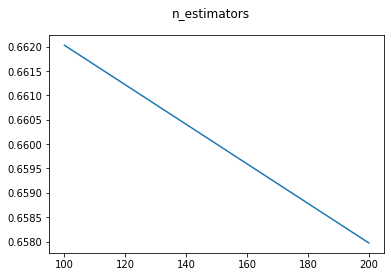

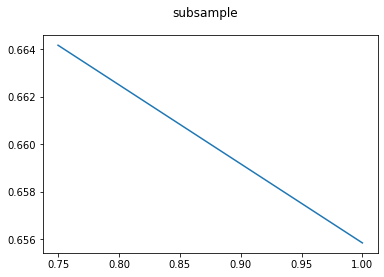

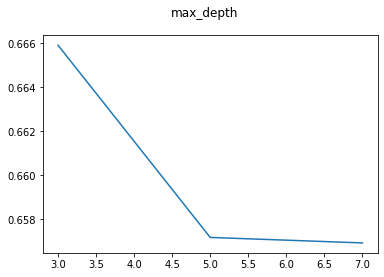

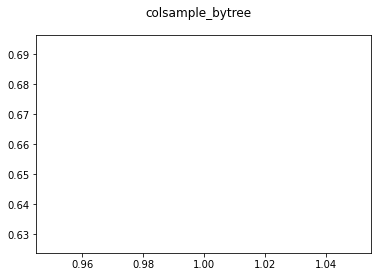

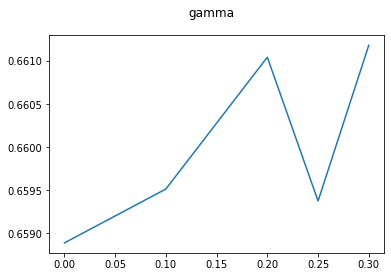

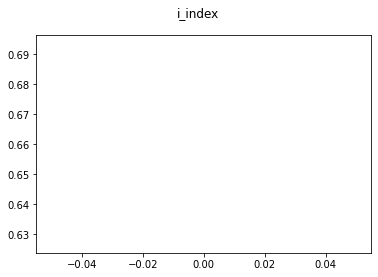

,learning_rate,n_estimators,subsample,max_depth,colsample_bytree,gamma,i_index,auc1,auc2,auc3,auc_avg
55,0.01,200,0.75,3,1,0.25,0,0.66,0.75,0.7,0.703333
57,0.01,200,0.75,3,1,0.20,0,0.66,0.75,0.7,0.703333


In [228]:
#### 3.2 Factor analysis

# 1. Look at data dynamic
# 1.1 Select need param
k =  ['learning_rate','n_estimators', 'subsample', 'max_depth','colsample_bytree','gamma','i_index']


# 1.2 Plot data
for X in k:
    t =grid_tab.groupby(X)[['auc_avg']].agg(np.mean)

    # Plot the data
    x = np.array(t.index)
    y  = np.array(t['auc_avg'])
    plt.plot(x, y)
    plt.suptitle(X)
    plt.show()
    
# 1.3 select the best param    
grid_tab[grid_tab.auc_avg == grid_tab.auc_avg.max()]    

#### 3.3 Result Advanced XGBoost model

In [268]:
%%time

threshold = 0.25
# 1. fitting 

xg_reg = xgb.XGBClassifier( n_jobs=7, random_state=777, objective='reg:logistic', use_label_encoder=False,
                         learning_rate = 0.01,
                          n_estimators = 200,
                          subsample = 0.75,
                          max_depth = 3,
                          colsample_bytree = 1,
                          gamma = 0.25
                          )
xg_reg.fit(x_train, y_train)


# 2. Prediction
pred = xg_reg.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred)
print('AUC: ', round(auc(fpr, tpr),2))


# 3. Prediction + threshold
prediction = np.where(pred  < threshold, 0, 1)


print('recall: ', round(recall_score(y_pred = prediction, y_true = y_test),2))
print(confusion_matrix(y_test, prediction))

AUC:  0.76
recall:  0.36
[[424  38]
 [ 35  20]]
Wall time: 149 ms


#### 3.4 Dependdens recall on threshold 

In [266]:
rec_prec_threshold = pd.DataFrame({'threshold':np.arange(0.01, 0.5, 0.01),
             'Recall':np.nan,
              'Precision': np.nan} )


for i in range(len(rec_prec_threshold)):
    prediction = np.where(pred < rec_prec_threshold['threshold'][i], 0, 1)
    rec_prec_threshold['Recall'][i]  = round(recall_score(y_pred = prediction, y_true = y_test),2)
    rec_prec_threshold['Precision'][i]  = round(precision_score(y_pred = prediction, y_true = y_test),2)
    

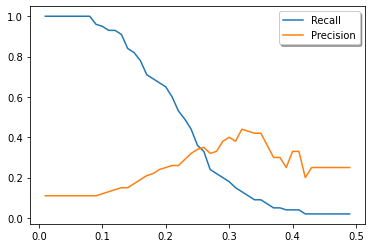

In [272]:
x = rec_prec_threshold.threshold
y  = rec_prec_threshold.Recall
z = rec_prec_threshold.Precision_score
plt.plot(x, y);
plt.plot(x, z);
plt.legend(['Recall','Precision' ],shadow = True, loc = 1);    

In [274]:
rec_prec_threshold

,threshold,Recall,Precision_score
0,0.01,1.00,0.11
1,0.02,1.00,0.11
2,0.03,1.00,0.11
3,0.04,1.00,0.11
4,0.05,1.00,0.11
5,0.06,1.00,0.11
6,0.07,1.00,0.11
7,0.08,1.00,0.11
8,0.09,0.96,0.11
9,0.10,0.95,0.12


#### Part 4. Conclusion

In [275]:
#  Result model 
model = xg_reg

# Model AUC
pred = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred)
print('AUC: ', round(auc(fpr, tpr),2))


# В зависимости от цели задачи необходимо установить "порог" для определения плохих клиентов.
# Чем меньше порог, тем больше плохих клиентов получаеться отлавиливать, но возрастает ошибка первого рода.
# Рекомендую использовать график выше для определения оптимального порога, например,
# Если задача идентифицировать 50% плохих клиентов, то порог 0.23

# 3. Prediction + threshold
threshold = 0.23
prediction = np.where(pred  < threshold, 0, 1)


# 4. Итоговая confusion_matrix
print('recall: ', round(recall_score(y_pred = prediction, y_true = y_test),2))
print(confusion_matrix(y_test, prediction))

AUC:  0.76
recall:  0.49
[[397  65]
 [ 28  27]]


In [43]:
x_train.columns

Index(['credit_amount', 'age', 'income', 'month', 'credit_term',
       'phone_operator', 'product_type_Cell phones',
       'education_Secondary special education', 'having_children_flg',
       'family_status_Married', 'is_male', 'y', 'fold'],
      dtype='object')

In [60]:
x_train.shape

(1206, 13)

In [61]:
x_train.columns

Index(['credit_amount', 'age', 'income', 'month', 'credit_term',
       'phone_operator', 'product_type_Cell phones',
       'education_Secondary special education', 'having_children_flg',
       'family_status_Married', 'is_male', 'y', 'fold'],
      dtype='object')

In [58]:
xg_reg.predict_proba(x_test)[:, 1]

array([0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126779,
       0.00126779, 0.00126779, 0.00126779, 0.00126779, 0.00126

In [ ]:
# 1. xgb model
# 2. Treshold and CM
# 3. Delete extrme deals

### Part 2. Moddelling

#### 2. First attempt to create a model with default parametres.

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
%%time
rf_def = RandomForestClassifier(n_estimators=500)
rf_def.fit(x_train, y_train)

Wall time: 823 ms


RandomForestClassifier(n_estimators=500)

In [38]:
print('MAE: ',recall_score(y_test, rf_def.predict(x_test) ))

MAE:  0.01818181818181818


In [ ]:
%%time
rf_def = RandomForestClassifier(n_estimators=500)
rf_def.fit(x_train, y_train)
print('MAE: ',recall_score(y_test, rf_def.predict(x_test) ))

#### 3. Feature importance 

In [40]:
feature_importances = pd.DataFrame(rf_def.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
feature_importances

,importance
credit_amount,0.155089
age,0.143201
income,0.123815
month,0.105956
credit_term,0.089765
phone_operator,0.061750
product_type_Cell phones,0.043343
having_children_flg,0.027407
is_client,0.026402
is_male,0.025673


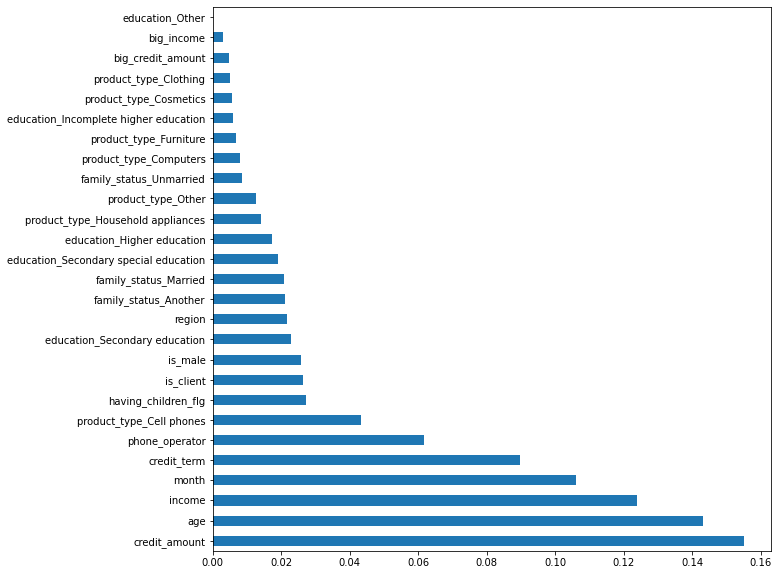

In [42]:
feat_importances = pd.Series(rf_def.feature_importances_, index = x_train.columns)
plot1 = feat_importances.nlargest(50).plot(kind='barh', figsize = (10,10))
plot1.tick_params(axis = 'both', which = 'major', labelsize = 10);

#### 4. Determine thebest features

In [43]:
columns = feature_importances[feature_importances['importance']>0.025].index.tolist()
columns
#columns

['credit_amount',
 'age',
 'income',
 'month',
 'credit_term',
 'phone_operator',
 'product_type_Cell phones',
 'having_children_flg',
 'is_client',
 'is_male']

In [45]:
%%time
rf_def = RandomForestClassifier(n_estimators=500)
rf_def.fit(x_train, y_train)
print('MAE: ',recall_score(y_test, rf_def.predict(x_test) ))
print(confusion_matrix(y_test, prediction))

MAE:  0.03636363636363636
[[442  20]
 [ 49   6]]
Wall time: 908 ms


#### 5. Comparison of algortms with default parametres

In [49]:
# Spot Check Algorithms
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('GBM',  GradientBoostingClassifier()))
models.append(('AB',  AdaBoostClassifier()))



In [56]:
%%time

# Test options and evaluation metric using Root Mean Square error method
num_folds = 5
seed = 7
scoring = 'recall'


results = []
names = []


for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RF: 0.042849 (0.025037)
GBM: 0.059943 (0.030730)
AB: 0.079886 (0.042923)
Wall time: 2.04 s


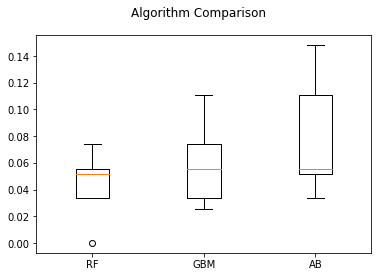

In [60]:
# Compare algoritmes
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Determine the best methods

In [68]:
res = []

# Create vector of model names
for i in np.arange(0,3):
    res.append(models[i][0])

# create vector of with names of models and their metrics of quality
data_model = pd.DataFrame(np.mean(results, axis=1), res, columns = ['recall'])
data_model = data_model.sort_values(by=['recall'], ascending= False)
data_model

,recall
AB,0.079886
GBM,0.059943
RF,0.042849


#### Tune scaled GBM

Calculate the time ofcalculation for 1 iteration

##### 1 -st attempt

In [93]:
%%time

model = AdaBoostClassifier()
kfold = KFold(n_splits=num_folds)
kfold  =5


grid = GridSearchCV(estimator=model,cv=kfold, scoring='recall',
                  param_grid={
                    'n_estimators':  [50,100,500],
                    'learning_rate': [0.05,0.5,1],
                    })


grid_result = grid.fit(train,  y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']


# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.251154 using {'learning_rate': 1, 'n_estimators': 500}
Wall time: 19.7 s


In [97]:



# prepare the model
model = AdaBoostClassifier( n_estimators = 500,
                           learning_rate = 1)
model.fit(x_train, y_train)
# transform the validation dataset

predictions = model.predict( x_test)
print( recall_score(y_test, predictions))

0.07272727272727272


In [408]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


gs = GridSearchCV(RandomForestRegressor(n_estimators=100),
                  param_grid={
                        'max_depth': np.arange(2,50,4),
                        'min_samples_split': np.arange(2,20,4),
                        'min_samples_leaf': np.arange(2,20,4),
                      'max_features': [None, 'log2', 'sqrt']
                  },
                  cv=cv,
                  scoring='neg_mean_absolute_error')
# verbose. Look at this parametres

In [409]:
%%time
gs.fit(df_train.drop(['medv'], axis = 1), df_train['medv'])

Wall time: 15min 57s


GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46]), 'min_samples_split': array([ 2,  6, 10, 14, 18]), 'min_samples_leaf': array([ 2,  6, 10, 14, 18]), 'max_features': [None, 'log2', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [261]:
pd.DataFrame(gs.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\depr

,params,mean_test_score,std_test_score
0,"{'max_depth': 2, 'max_features': None, 'min_sa...",-2.723341,0.207946
1,"{'max_depth': 2, 'max_features': None, 'min_sa...",-2.709505,0.210681
2,"{'max_depth': 2, 'max_features': None, 'min_sa...",-2.705841,0.218698
3,"{'max_depth': 2, 'max_features': None, 'min_sa...",-2.714064,0.213262
4,"{'max_depth': 2, 'max_features': None, 'min_sa...",-2.731933,0.189346
5,"{'max_depth': 2, 'max_features': None, 'min_sa...",-2.733962,0.236855
6,"{'max_depth': 2, 'max_features': None, 'min_sa...",-2.790819,0.221137
7,"{'max_depth': 2, 'max_features': None, 'min_sa...",-2.672156,0.247139
8,"{'max_depth': 2, 'max_features': None, 'min_sa...",-2.771207,0.219014
9,"{'max_depth': 2, 'max_features': None, 'min_sa...",-2.695489,0.244259


In [411]:
print('MAE: ', -gs.best_score_)
print('Best parametres: ',gs.best_params_)

MAE:  2.0005002269160244
Best parametres:  {'max_depth': 22, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}


In [83]:
# parametrization
RF_best = RandomForestRegressor(max_depth =  58,max_features = 'sqrt', min_samples_leaf = 2, min_samples_split =  2,n_estimators=100)

# fitting
#knn_best.fit(X_train, y_train)


In [84]:
RF_best.fit(df_train.drop(['medv'], axis = 1), df_train['medv'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=58,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [262]:
from sklearn.model_selection import train_test_split, StratifiedKFold
X_train, X_holdout, y_train, y_holdout = train_test_split(df_train.drop(['medv'], axis = 1), df_train['medv'], test_size=0.3,
                                                          random_state=17)

In [263]:
RF_best = RandomForestRegressor(max_depth =  58,max_features = 'sqrt', min_samples_leaf = 2, min_samples_split =  2,n_estimators=100)

RF_best.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=58,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [264]:
RF_best.score(X_holdout, y_holdout)

0.7859208781522237

In [265]:
from sklearn.metrics import mean_absolute_error
#mean_absolute_erro

In [266]:
mean_absolute_error(y_holdout, RF_best.predict(X_holdout) )

2.4731475485743375

In [267]:
RF_best.score

<bound method RegressorMixin.score of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=58,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)>

#### Find the best  range for grid search

In [440]:
from operator import itemgetter

# Utility function to report best scores
def report(grid_scores, n_top):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.4f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [ ]:
report(grid_search.grid_scores_, 4)

#### 5. Feature importance 

In [268]:
feature_importances = pd.DataFrame(RF_best.feature_importances_,
                                   index = df_train.drop(['medv'], axis = 1).columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
feature_importances 

,importance
lstat,0.228846
rm,0.144035
nox,0.105277
crim,0.102910
dis,0.068276
ptratio,0.067786
indus,0.061708
age,0.055990
tax,0.045134
high_crim,0.036011


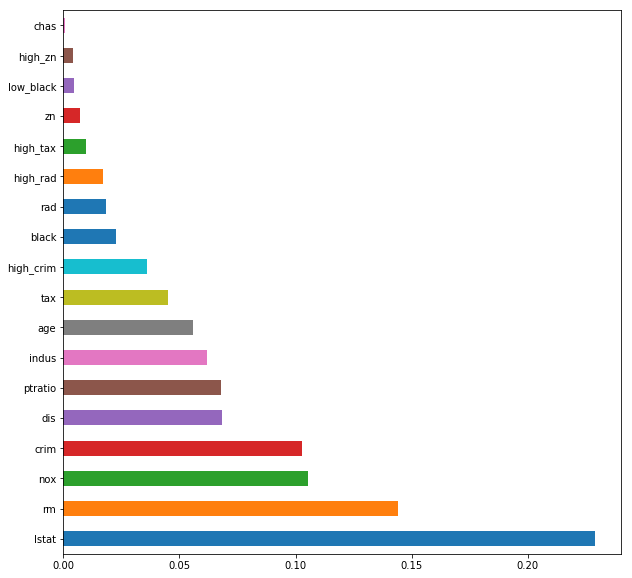

In [269]:
feat_importances = pd.Series(RF_best.feature_importances_, index = df_train.drop(['medv'], axis = 1).columns)
plot1 = feat_importances.nlargest(1000).plot(kind='barh', figsize = (10,10))
plot1.tick_params(axis = 'both', which = 'major', labelsize = 10);

In [44]:
df_train.describe()

,crim,zn,indus,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,-0.823320,10.318306,2.166516,-0.613492,1.831259,4.077534,1.224869,9.663934,408.950820,18.559016,354.595246,2.418944,21.017486
std,2.163990,21.508117,0.758435,0.202156,0.073986,0.623569,0.528321,8.783806,169.282508,2.053040,96.567695,0.526958,6.528431
min,-5.064036,0.000000,-0.301105,-0.936493,1.645963,1.064711,0.274825,1.000000,187.000000,12.600000,0.320000,0.683097,5.000000
25%,-2.527357,0.000000,1.646734,-0.802405,1.779096,3.816611,0.774024,4.000000,281.750000,17.400000,376.280000,2.022204,17.100000
50%,-1.534171,0.000000,2.271094,-0.638688,1.827931,4.312809,1.213918,5.000000,330.000000,19.100000,391.880000,2.448397,21.050000
75%,1.347159,12.500000,2.895912,-0.471605,1.880228,4.542762,1.686529,24.000000,666.000000,20.200000,396.270000,2.836290,24.400000
max,4.488369,95.000000,3.322875,-0.138113,2.004179,4.605170,2.495393,24.000000,711.000000,22.000000,396.900000,3.526949,37.900000


Сделаем разбиения для кросс-валидации

In [45]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(shuffle=True, random_state=241)

Теперь переберем разные параметры для дерева

Решающие леса

In [49]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(RandomForestRegressor(n_estimators=10),
                  param_grid={
                              'max_depth': np.linspace(2.0, 50, num=49)},
                  cv=cv,
                  scoring='r2')

In [50]:
gs.fit(df_train.drop(['medv'], axis = 1), df_train['medv'])

GridSearchCV(cv=KFold(n_splits=3, random_state=241, shuffle=True),
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
       41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [51]:
pd.DataFrame(gs.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\depr

,params,mean_test_score,std_test_score
0,{'max_depth': 2.0},0.704452,0.035638
1,{'max_depth': 3.0},0.731959,0.014162
2,{'max_depth': 4.0},0.767194,0.004861
3,{'max_depth': 5.0},0.773574,0.015968
4,{'max_depth': 6.0},0.784171,0.002942
5,{'max_depth': 7.0},0.787186,0.006573
6,{'max_depth': 8.0},0.798993,0.019311
7,{'max_depth': 9.0},0.799058,0.016909
8,{'max_depth': 10.0},0.789341,0.018068
9,{'max_depth': 11.0},0.778803,0.023279


In [52]:
gs.best_params_

{'max_depth': 18.0}

In [53]:
# parametrization
RF_best = RandomForestRegressor(max_depth = 48 )

# fitting
#knn_best.fit(X_train, y_train)


In [54]:
RF_best.fit(df_train.drop(['medv'], axis = 1), df_train['medv'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=48,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Part 4. predictions 

In [141]:
df_test = pd.read_csv('boston_test_data.csv', sep=',' )

In [142]:
d_predictions = RF_best.predict(df_test)

d_predictions

array([35.66, 21.05, 18.12, 24.74, 19.05, 24.95, 19.3 , 16.03, 18.62,
       44.54, 46.75, 11.54, 15.39, 34.96, 26.6 ,  9.97, 22.22, 20.07,
       19.78, 12.01, 22.65, 31.04, 13.66,  9.97, 21.26, 21.59, 35.28,
       19.89, 19.08, 48.47, 24.57, 12.01, 22.24, 20.37, 20.76, 41.13,
       26.88, 42.79, 21.88, 14.56, 14.62, 50.  , 20.42, 15.97, 32.03,
       20.87, 19.3 , 21.5 , 20.53, 16.75, 23.48, 15.61, 21.02, 12.63,
       26.22, 20.7 , 20.57, 22.74, 19.73, 20.2 , 41.24, 18.39, 14.75,
       21.16, 32.39,  9.07, 19.73, 21.49, 18.68, 14.74, 31.51, 20.94,
       19.52, 30.56, 18.25, 19.56, 21.08, 21.5 , 29.67, 33.04, 20.12,
       18.66, 27.93, 10.32, 34.06,  8.32, 15.91, 16.58, 19.43, 14.64,
       19.8 , 48.76, 41.17, 17.04, 30.21, 15.74, 34.14, 23.73, 22.2 ,
       18.08, 45.35, 44.61])

In [144]:
res = pd.DataFrame({"Price":d_predictions} )

res.to_csv('C://Users//user//Desktop//ML//kaggle//Boston//res_RF_2.csv', index = True)

In [ ]:

df_test = pd.read_csv('boston_test_data.csv', sep=',' )

# 1 Correct test data
df_test['crim'] = np.log(df_test['crim'] ) 
df_test['indus'] = np.log(df_test['indus'] ) 
df_test['chas'] = df_test['chas'].astype('category')
df_test['nox'] = np.log(df_test['nox'] ) 
df_test['rm'] = np.log(df_test['rm'] ) 
df_test['age'] = np.log(df_test['age'] ) 
df_test['dis'] = np.log(df_test['dis'] ) 
df_test['lstat'] = np.log(df_test['lstat'] ) 

d_predictions = regr.predict(df_test.values)

d_predictions

res = pd.DataFrame({"Price":d_predictions} )

res.to_csv('C://Users//user//Desktop//ML//kaggle//Boston//res_2.csv', index = True)